----
### Step 4: Explore an Improvement for a Model

There are many things you can do once you have the basic classifier in place. One example would be to also localize where the numbers are on the image. The SVHN dataset provides bounding boxes that you can tune to train a localizer. Train a regression loss to the coordinates of the bounding box, and then test it. 

In [1]:
import os
import sys
from six.moves.urllib.request import urlretrieve
import tensorflow as tf
import matplotlib.pyplot as plt
import numpy as np
import idx2numpy
import time
from scipy.io import loadmat
from PIL import Image
import pickle

In [2]:
import pandas as pd

traincsv = './uncropped_data/train/bbtrain.csv'
testcsv = './uncropped_data/test/bbtest.csv'

df_single_train = pd.read_csv(traincsv)
df_single_test = pd.read_csv(testcsv)

In [3]:
print(df_single_train.head())
print(df_single_train.tail())

print(df_single_test.head())
print(df_single_test.tail())

  FileName  DigitLabel  Left  Top  Width  Height
0    1.png           1   246   77     81     219
1    1.png           9   323   81     96     219
2    2.png           2    77   29     23      32
3    2.png           3    98   25     26      32
4    3.png           2    17    5      8      15
        FileName  DigitLabel  Left  Top  Width  Height
73252  33401.png           2    34    6     25      40
73253  33401.png           2    61    4     25      40
73254  33402.png           1    35   10      7      25
73255  33402.png           6    44    8     15      25
73256  33402.png           9    62    9     17      25
  FileName  DigitLabel  Left  Top  Width  Height
0    1.png           5    43    7     19      30
1    2.png           2    99    5     14      23
2    2.png           1   114    8      8      23
3    2.png          10   121    6     12      23
4    3.png           6    61    6     11      16
        FileName  DigitLabel  Left  Top  Width  Height
26027  13067.png           

In [4]:
lefts_train = df_single_train.groupby('FileName')['Left'].min()
tops_train = df_single_train.groupby('FileName')['Top'].min()
heights_train = df_single_train.groupby('FileName')['Height'].max()

first_left_train = df_single_train.groupby('FileName').min()['Left']
last_left_train = df_single_train.groupby('FileName').max()['Left']
last_width_train = df_single_train.groupby('FileName').last()['Width']
widths_train = last_left_train + last_width_train - first_left_train 

lefts_test = df_single_test.groupby('FileName')['Left'].min()
tops_test = df_single_test.groupby('FileName')['Top'].min()
heights_test = df_single_test.groupby('FileName')['Height'].max()

first_left_test = df_single_test.groupby('FileName').min()['Left']
last_left_test = df_single_test.groupby('FileName').max()['Left']
last_width_test = df_single_test.groupby('FileName').last()['Width']
widths_test = last_left_test + last_width_test - first_left_test 

## Next Steps

Now that we have a series for each of the left, top, width, and height of the bounding box for each image, we want to arrange them into a DataFrame to prepare for cropping

In [5]:
df_crop_train = lefts_train.to_frame().join(tops_train.to_frame()).join(widths_train.to_frame()).join(heights_train.to_frame())
df_crop_test = lefts_test.to_frame().join(tops_test.to_frame()).join(widths_test.to_frame()).join(heights_test.to_frame())

In [6]:
df_crop_train.columns = ['Left','Top','Width','Height']
df_crop_test.columns = ['Left','Top','Width','Height']
df_crop_train.head()

,Left,Top,Width,Height
FileName,,,,
1.png,246,77,173,219
10.png,25,4,23,27
100.png,18,0,24,22
1000.png,17,1,10,18
10000.png,45,20,43,29


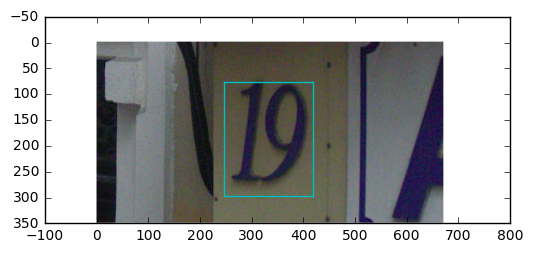

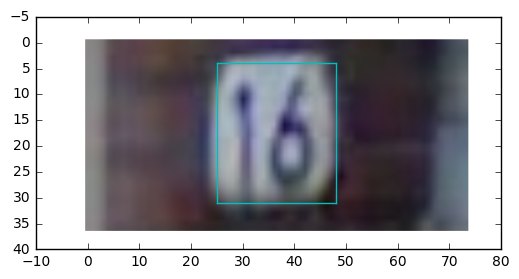

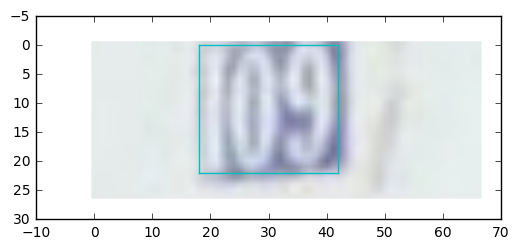

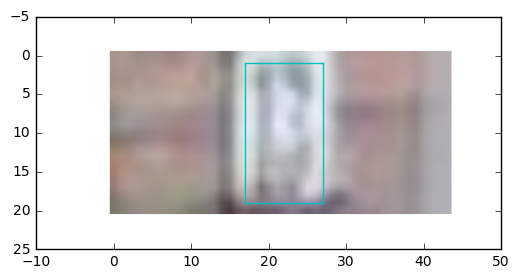

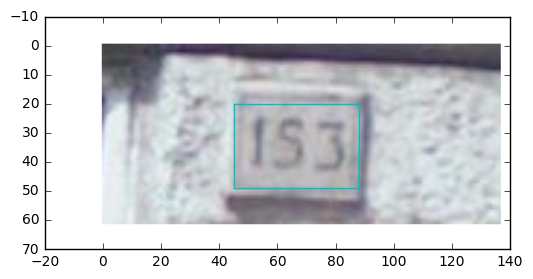

In [7]:
head_images = [1,10,100,1000,10000]

for i in head_images:
    image_name = '{}.png'.format(i)
    example_image = './uncropped_data/train/' + image_name
    img = Image.open(example_image)
    imgplot = plt.imshow(img)
    
    left = df_crop_train.loc[image_name]['Left']    
    top = df_crop_train.loc[image_name]['Top']    
    width = df_crop_train.loc[image_name]['Width']    
    height = df_crop_train.loc[image_name]['Height']
    
    plt.plot([left, left], [top, top + height], 'c')
    plt.plot([left, left+width], [top, top], 'c')
    plt.plot([left+width, left+width], [top, top+height], 'c')
    plt.plot([left, left+width], [top+height, top+height], 'c')
    
    plt.show()

Before cropping, it is suggested that we expand the bounding boxes by 30% in each direction. This will involve subtracting 30% of the width from the left column, subtracting 30% of the height from the top, etc. We must also ensure that this expansion does not go past the edge of the image, so we need to get the true height and width for each image.

In [8]:
df_crop_train['ImageX'] = np.nan
df_crop_train['ImageY'] = np.nan

df_crop_test['ImageX'] = np.nan
df_crop_test['ImageY'] = np.nan

In [9]:
def set_image_dims(df_crop, test=False):
    max_num = df_crop.shape[0]
    for i in range(1, max_num+1):
        folder = str()
        if test:
            folder = './uncropped_data/test/'
        else:
            folder = './uncropped_data/train/'
        
        image_name = '{}.png'.format(i)
        example_image = folder + image_name
        
        img = Image.open(example_image)
        width, height = img.size
        df_crop.set_value(image_name, ['ImageX'], width)
        df_crop = df_crop.set_value(image_name, ['ImageY'], height)

In [10]:
set_image_dims(df_crop_train, test=False)
set_image_dims(df_crop_test, test=True)

In [11]:
df_crop_train.head()
df_crop_test.head()

df_crop_train.isnull().values.any()
df_crop_test.isnull().values.any()

False

Now that we have the image dimensions, we can apply a function to the columns of the DataFrame that expands the bounding boxes. 

In [12]:
def fixLeft(row):
    return max( row['Left'] - 0.3 * row['Width'] , 0 )

df_crop_train['cropLeft'] = df_crop_train.apply(fixLeft, axis=1)
df_crop_test['cropLeft'] = df_crop_test.apply(fixLeft, axis=1)

def fixTop(row):
    return max( row['Top'] - 0.3 * row['Height'] , 0 )

df_crop_train['cropTop'] = df_crop_train.apply(fixTop, axis=1)
df_crop_test['cropTop'] = df_crop_test.apply(fixTop, axis=1)

In [13]:
def fixWidth(row):
    return( min( 1.6 * row['Width'], row['ImageX'] - row['cropLeft']))

df_crop_train['cropWidth'] = df_crop_train.apply(fixWidth, axis=1)
df_crop_test['cropWidth'] = df_crop_test.apply(fixWidth, axis=1)

def fixHeight(row):
    if row['Top'] + 1.6 * row['Height'] > row['ImageY']:
        return row['ImageY'] - row['cropTop']
    else:
        return 1.6 * row['Height']

df_crop_train['cropHeight'] = df_crop_train.apply(fixHeight, axis=1)
df_crop_test['cropHeight'] = df_crop_test.apply(fixHeight, axis=1)

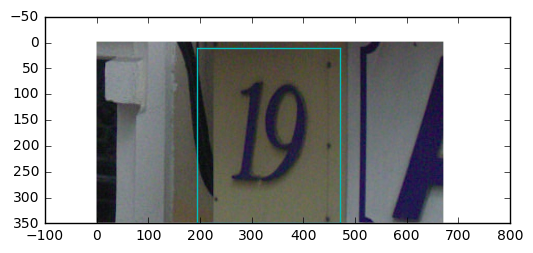

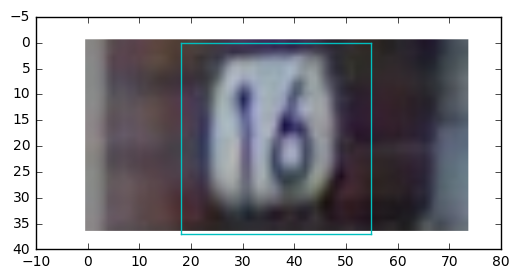

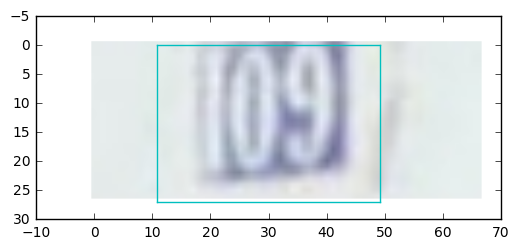

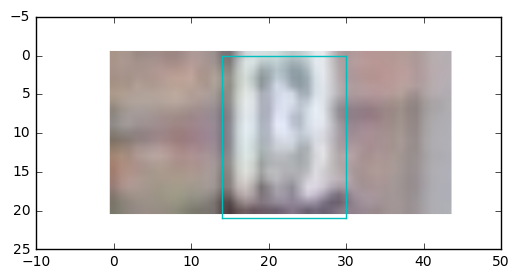

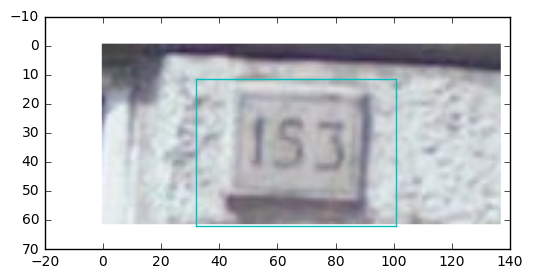

In [14]:
for i in head_images:
    image_name = '{}.png'.format(i)
    example_image = './uncropped_data/train/' + image_name
    img = Image.open(example_image)
    imgplot = plt.imshow(img)
    
    left = df_crop_train.loc[image_name]['cropLeft']    
    top = df_crop_train.loc[image_name]['cropTop']    
    width = df_crop_train.loc[image_name]['cropWidth']    
    height = df_crop_train.loc[image_name]['cropHeight']
    
    
    plt.plot([left, left], [top, top + height], 'c')
    plt.plot([left, left+width], [top, top], 'c')
    plt.plot([left+width, left+width], [top, top+height], 'c')
    plt.plot([left, left+width], [top+height, top+height], 'c')
    
    plt.show()

In [15]:
df_crop_train.head()

,Left,Top,Width,Height,ImageX,ImageY,cropLeft,cropTop,cropWidth,cropHeight
FileName,,,,,,,,,,
1.png,246,77,173,219,741.0,350.0,194.1,11.3,276.8,338.7
10.png,25,4,23,27,74.0,37.0,18.1,0.0,36.8,37.0
100.png,18,0,24,22,67.0,27.0,10.8,0.0,38.4,27.0
1000.png,17,1,10,18,44.0,21.0,14.0,0.0,16.0,21.0
10000.png,45,20,43,29,137.0,62.0,32.1,11.3,68.8,50.7


In [16]:
df_crop_train = df_crop_train.drop(['Left','Top','Width','Height'], axis=1)
df_crop_test = df_crop_test.drop(['Left','Top','Width','Height'], axis=1)

Now it is time to crop and resize all of the images, while preserving the location of the bounding boxes. We have four DataFrames:
```
df_single_train
df_single_test
df_crop_train
df_crop_test
```
Once we crop the images, the original two DataFrames' information becomes incorrect. So from the Top and Left columns, we need to subtract the values of the cropTop and cropLeft. But first let's crop:

In [17]:
# DO NOT RUN AGAIN

def crop_images(df_crop, test=False):
    max_num = df_crop.shape[0]
    for i in range(1, max_num + 1):
        image_name = '{}.png'.format(i)
        folder = './uncropped_data/'
        if test:
            folder = folder + 'test/'
        else:
            folder = folder + 'train/'
        example_image = folder + image_name
        img = Image.open(example_image)
        
        # locate the top, left, width, and height of the crop
        left = df_crop.loc[image_name]['cropLeft']    
        top = df_crop.loc[image_name]['cropTop']    
        width = df_crop.loc[image_name]['cropWidth']    
        height = df_crop.loc[image_name]['cropHeight']
        
        # create a new image during a crop, and save to the folder
        newfolder = './uncropped_data/'
        if test:
            newfolder = newfolder + 'cropTest/'
        else:
            newfolder = newfolder + 'cropTrain/'
        
        new_image_loc = newfolder + image_name
        
        img2 = img.crop(( left, top, width+left, height+top ))
        img2 = img2.resize((64,64))
        img2.save(new_image_loc)
        

crop_images(df_crop_train, test=False)
crop_images(df_crop_test, test=True)

In [18]:
def display_image(image_name, crop=False, test=False):
    folder = './uncropped_data/'
    
    if crop and test:
        folder = folder + 'cropTest/'
    elif crop and not test:
        folder = folder + 'cropTrain/'
    elif not crop and test:
        folder = folder + 'test/'
    else:
        folder = folder + 'train/'
    
    example_image = folder + image_name
    img = Image.open(example_image)
    plt.imshow(img)
    plt.show()

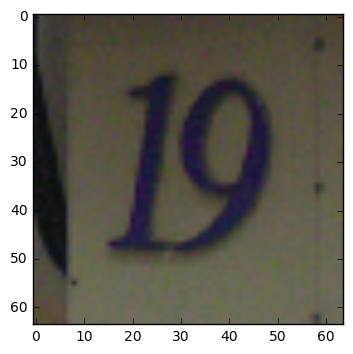

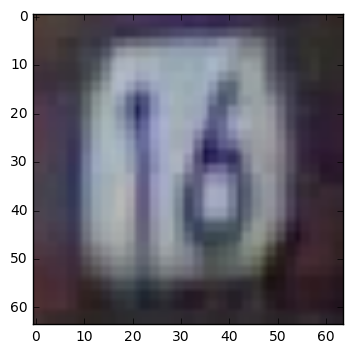

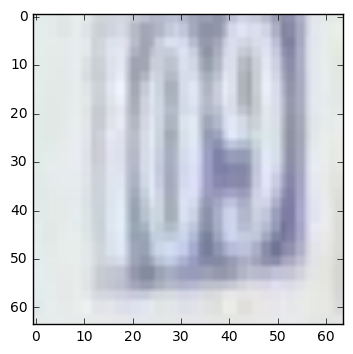

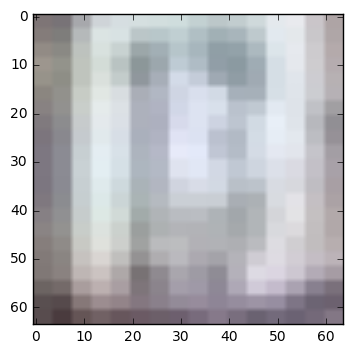

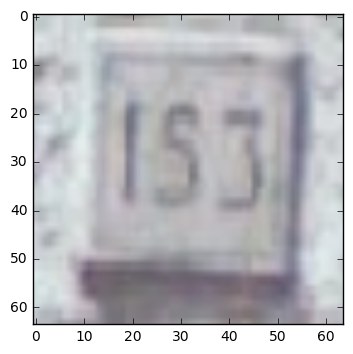

In [19]:
for image in head_images:
    image = str(image)
    display_image(image+'.png', crop=True)

The cropping is finished! Now we need to get the values of the bounding boxes. This will be easiest if we just add the values for the transformed boxes to the original DataFrames

In [20]:
test_df_single = df_single_train.iloc[:20]
test_df_crop = df_crop_train.loc[['1.png','2.png','3.png','4.png','5.png','6.png','7.png','8.png','9.png']]
print(test_df_single)
test_df_crop

   FileName  DigitLabel  Left  Top  Width  Height
0     1.png           1   246   77     81     219
1     1.png           9   323   81     96     219
2     2.png           2    77   29     23      32
3     2.png           3    98   25     26      32
4     3.png           2    17    5      8      15
5     3.png           5    25    5      9      15
6     4.png           9    57   13     15      34
7     4.png           3    72   13     13      34
8     5.png           3    52    7     21      46
9     5.png           1    74   10     15      46
10    6.png           3    28    6     10      21
11    6.png           3    38    8     11      21
12    7.png           2    35   10     13      32
13    7.png           8    47   11     13      32
14    8.png           7    17    4      7      15
15    8.png           4    25    4      6      15
16    8.png           4    31    3      7      15
17    9.png           1    19    4     14      24
18    9.png           2    29    4     13      24


,ImageX,ImageY,cropLeft,cropTop,cropWidth,cropHeight
FileName,,,,,,
1.png,741.0,350.0,194.1,11.3,276.8,338.7
2.png,199.0,83.0,62.9,15.4,75.2,51.2
3.png,52.0,23.0,11.9,0.5,27.2,22.5
4.png,161.0,79.0,48.6,2.8,44.8,54.4
5.png,140.0,68.0,40.9,0.0,59.2,68.0
6.png,74.0,35.0,21.7,0.0,33.6,35.0
7.png,99.0,54.0,27.5,0.4,40.0,53.6
8.png,54.0,22.0,10.7,0.0,33.6,22.0
9.png,79.0,34.0,8.2,0.0,57.6,34.0


In [21]:
# These functions calculate the new locations for the bounding boxes
# based on a crop a translation to this image size:

image_size = 64.0

def get_new_top(oldTop, cropTop, cropHeight):
    newTop = oldTop - cropTop
    newTop *= image_size/cropHeight
    return newTop

def get_new_left(oldLeft, cropLeft, cropWidth):
    newLeft = oldLeft - cropLeft
    newLeft *= image_size/cropWidth
    return newLeft

def get_new_width(oldWidth, cropWidth):
    newWidth = image_size*oldWidth/cropWidth
    return newWidth

def get_new_height(oldHeight, cropHeight):
    newHeight = image_size*oldHeight/cropHeight
    return newHeight

In [22]:
def cropped_bbs(df_single, df_crop):
    max_num = df_crop.shape[0]
    
    # add 20 new columns to our crop DataFrame
    df_crop['d1_bb_top'] = np.nan
    df_crop['d1_bb_left'] = np.nan
    df_crop['d1_bb_width'] = np.nan
    df_crop['d1_bb_height'] = np.nan
    
    df_crop['d2_bb_top'] = np.nan
    df_crop['d2_bb_left'] = np.nan
    df_crop['d2_bb_width'] = np.nan
    df_crop['d2_bb_height'] = np.nan
    
    df_crop['d3_bb_top'] = np.nan
    df_crop['d3_bb_left'] = np.nan
    df_crop['d3_bb_width'] = np.nan
    df_crop['d3_bb_height'] = np.nan
    
    df_crop['d4_bb_top'] = np.nan
    df_crop['d4_bb_left'] = np.nan
    df_crop['d4_bb_width'] = np.nan
    df_crop['d4_bb_height'] = np.nan
    
    df_crop['d5_bb_top'] = np.nan
    df_crop['d5_bb_left'] = np.nan
    df_crop['d5_bb_width'] = np.nan
    df_crop['d5_bb_height'] = np.nan
    
    for i in range(1, max_num+1):
        image = str(i) + '.png'
        
        cropTop = df_crop.loc[image]['cropTop']
        cropLeft = df_crop.loc[image]['cropLeft']
        cropHeight = df_crop.loc[image]['cropHeight']
        cropWidth = df_crop.loc[image]['cropWidth']
        
        df_slice = df_single[df_single['FileName'] == image]
        num_digits = df_slice.shape[0]
        
        for digit_place in range(1,6):
            d_holder = 'd' + str(digit_place) + '_bb_'
            
            if digit_place <= num_digits:
                
                oldTop = df_slice.iloc[digit_place-1]['Top']
                oldLeft = df_slice.iloc[digit_place-1]['Left']
                oldWidth = df_slice.iloc[digit_place-1]['Width']
                oldHeight = df_slice.iloc[digit_place-1]['Height']
                
                newTop = get_new_top(oldTop, cropTop, cropHeight)
                newLeft = get_new_left(oldLeft, cropLeft, cropWidth)
                newWidth = get_new_width(oldWidth, cropWidth)
                newHeight = get_new_height(oldHeight, cropHeight)
                
                df_crop.set_value(image, [d_holder+'top'], newTop)
                df_crop.set_value(image, [d_holder+'left'], newLeft)
                df_crop.set_value(image, [d_holder+'width'], newWidth)
                df_crop.set_value(image, [d_holder+'height'], newHeight)
            
            else:
                # For blank digits, we will put the bounding box 
                # outside the range of the image
                df_crop.set_value(image, [d_holder+'top'], 0)
                df_crop.set_value(image, [d_holder+'left'], 65)
                df_crop.set_value(image, [d_holder+'width'], 10)
                df_crop.set_value(image, [d_holder+'height'], 10)

In [23]:
cropped_bbs(df_single_train, df_crop_train)
cropped_bbs(df_single_test, df_crop_test)

In [24]:
df_crop_train.head()

,ImageX,ImageY,cropLeft,cropTop,cropWidth,cropHeight,d1_bb_top,d1_bb_left,d1_bb_width,d1_bb_height,...,d3_bb_width,d3_bb_height,d4_bb_top,d4_bb_left,d4_bb_width,d4_bb_height,d5_bb_top,d5_bb_left,d5_bb_width,d5_bb_height
FileName,,,,,,,,,,,,,,,,,,,,,
1.png,741.0,350.0,194.1,11.3,276.8,338.7,12.414526,12.0,18.728324,41.381754,...,10.000000,10.000000,0.0,65.0,10.0,10.0,0.0,65.0,10.0,10.0
10.png,74.0,37.0,18.1,0.0,36.8,37.0,10.378378,12.0,15.652174,46.702703,...,10.000000,10.000000,0.0,65.0,10.0,10.0,0.0,65.0,10.0,10.0
100.png,67.0,27.0,10.8,0.0,38.4,27.0,2.370370,12.0,8.333333,52.148148,...,16.666667,52.148148,0.0,65.0,10.0,10.0,0.0,65.0,10.0,10.0
1000.png,44.0,21.0,14.0,0.0,16.0,21.0,3.047619,12.0,16.000000,54.857143,...,10.000000,10.000000,0.0,65.0,10.0,10.0,0.0,65.0,10.0,10.0
10000.png,137.0,62.0,32.1,11.3,68.8,50.7,10.982249,12.0,13.953488,36.607495,...,16.744186,36.607495,0.0,65.0,10.0,10.0,0.0,65.0,10.0,10.0


In [25]:
def plot_crop_bbs(image_name, test=False):
    folder = './uncropped_data/'
    if test:
        folder += 'cropTest/'
    else:
        folder += 'cropTrain/'
    example_image = folder + image_name
    img = Image.open(example_image)
    plt.imshow(img)
    
    for digit_place in range(1,6):
        d_holder = 'd' + str(digit_place) + '_bb_'
        
        left = df_crop_train.loc[image_name][d_holder+'left']    
        top = df_crop_train.loc[image_name][d_holder+'top']    
        width = df_crop_train.loc[image_name][d_holder+'width']    
        height = df_crop_train.loc[image_name][d_holder+'height']
        
        plt.plot([left, left], [top, top + height], 'c')
        plt.plot([left, left+width], [top, top], 'c')
        plt.plot([left+width, left+width], [top, top+height], 'c')
        plt.plot([left, left+width], [top+height, top+height], 'c')
    
    plt.show()

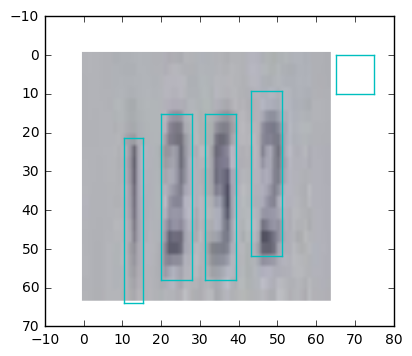

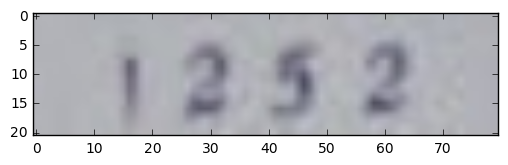

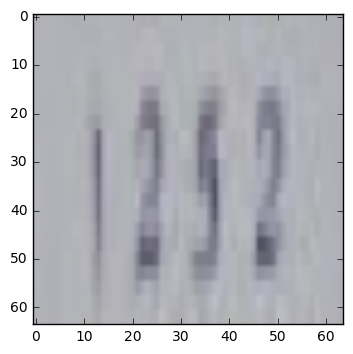

In [26]:
plot_crop_bbs('20000.png')
display_image('20000.png')
display_image('20000.png', crop=True)

We need to be able to plot the bounding boxes on the cropped images. Let's modify `df_crop_bb_train` to hold the bounding boxes for each image.

In [27]:
newcols = ['d1_bb_top', 'd1_bb_left', 'd1_bb_width', 'd1_bb_height',
          'd2_bb_top', 'd2_bb_left', 'd2_bb_width', 'd2_bb_height',
          'd3_bb_top', 'd3_bb_left', 'd3_bb_width', 'd3_bb_height',
          'd4_bb_top', 'd4_bb_left', 'd4_bb_width', 'd4_bb_height',
          'd5_bb_top', 'd5_bb_left', 'd5_bb_width', 'd5_bb_height']

for col in newcols:
    if df_crop_train[col].isnull().values.any():
        print('train',col)
    if df_crop_test[col].isnull().values.any():
        print('test',col)

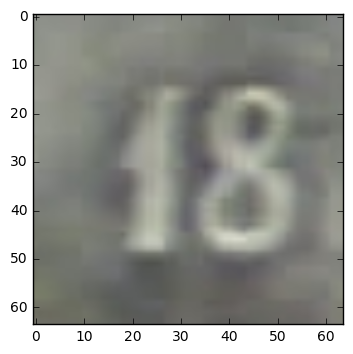

In [28]:
display_image('10036.png', test=True, crop=True)

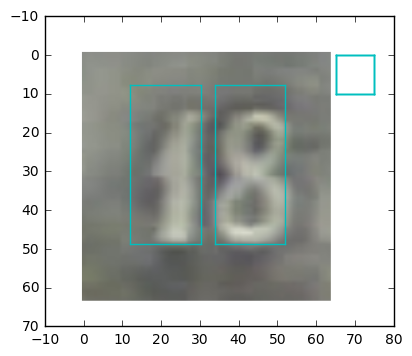

In [29]:
plot_crop_bbs('10036.png',test=True)

In [30]:
def get_bb_array(image_name, test=False):
    folder = './uncropped_data/'
    if test:
        folder += 'cropTest/'
    else:
        folder += 'cropTrain/'
    example_image = folder + image_name
    img = Image.open(example_image)
    
    bbs = []
    
    for digit_place in range(1,6):
        d_holder = 'd' + str(digit_place) + '_bb_'
        
        left = df_crop_train.loc[image_name][d_holder+'left']   
        top = df_crop_train.loc[image_name][d_holder+'top']    
        width = df_crop_train.loc[image_name][d_holder+'width']    
        height = df_crop_train.loc[image_name][d_holder+'height']
        
        bbs.append(left)
        bbs.append(top)
        bbs.append(width)
        bbs.append(height)
    
    img.close()
    return np.array(bbs).reshape((-1,4))

In [31]:
get_bb_array('10036.png',test=True)

array([[ 12.        ,   7.68      ,  18.18181818,  40.96      ],
       [ 33.81818182,   7.68      ,  18.18181818,  40.96      ],
       [ 65.        ,   0.        ,  10.        ,  10.        ],
       [ 65.        ,   0.        ,  10.        ,  10.        ],
       [ 65.        ,   0.        ,  10.        ,  10.        ]])

If seems the pipeline for processing images is complete. Next we need a metric. One way to evaluate the bounding boxes is by using the Intersect of Union. It is calculated as the area of the overlapping regions of the predicted and actual bounding boxes divided by the combined area. 

In [12]:
def batch_iou(a, b, epsilon=1e-5):
    """ 
    a and b are batches of bounding boxes, [left, top, width, height]
    
    I slightly modified the code from this tutorial:
    http://ronny.rest/tutorials/lesson/intersect_of_union/
    """
    
    a_rights = a[:, 0] + a[:, 2]
    a_bottoms = a[:, 1] + a[:, 3]
    
    b_rights = b[:, 0] + b[:, 2]
    b_bottoms = b[:, 1] + b[:, 3]
    
    # COORDINATES OF THE INTERSECTION BOXES
    x1 = np.array([a[:, 0], b[:, 0]]).max(axis=0)
    y1 = np.array([a[:, 1], b[:, 1]]).max(axis=0)
    x2 = np.array([a_rights, b_rights]).min(axis=0)
    y2 = np.array([a_bottoms, b_bottoms]).min(axis=0)

    # AREAS OF OVERLAP - Area where the boxes intersect
    width = (x2 - x1)
    height = (y2 - y1)

    # handle case where there is NO overlap
    width[width < 0] = 0
    height[height < 0] = 0

    area_overlap = width * height

    # COMBINED AREAS
    area_a = (a_rights - a[:, 0]) * (a_bottoms - a[:, 1])
    area_b = (b_rights - b[:, 0]) * (b_bottoms - b[:, 1])
    area_combined = area_a + area_b - area_overlap

    # RATIO OF AREA OF OVERLAP OVER COMBINED AREA
    iou = area_overlap / (area_combined + epsilon)
    return iou

In [33]:
batch_a = get_bb_array('10036.png', test=True)
pred_batch_a = np.array([1+i for i in batch_a])

In [34]:
batch_iou(batch_a, pred_batch_a)

array([ 0.79556984,  0.79556984,  0.57857139,  0.57857139,  0.57857139])

In [13]:
def metric(true_boxes, pred_boxes):
    ious = batch_iou(np.reshape(true_boxes, (-1, 4)), 
                     np.reshape(pred_boxes, (-1, 4)))
    return np.mean(ious)

In [36]:
image_size = 64
num_channels = 3

def make_datasets(valid_size = 5000):
    folder = './uncropped_data/'
    train_folder = folder + 'cropTrain/'
    test_folder = folder + 'cropTest/'
    
    train_size = len(os.listdir(train_folder)) - valid_size
    test_size = len(os.listdir(test_folder))
    
    train_dataset = np.ndarray(shape=(train_size, image_size, image_size, num_channels), dtype=np.float32)
    valid_dataset = np.ndarray(shape=(valid_size, image_size, image_size, num_channels), dtype=np.float32)
    test_dataset = np.ndarray(shape=(test_size, image_size, image_size, num_channels), dtype=np.float32)
        
    for i in range(1,train_size+1):
        image = str(i) + '.png'
        img = Image.open( train_folder + image )
        data = np.asarray( img, dtype=np.float32 )
        img.close()
        train_dataset[i-1,:,:,:] = data
        
    for i in range(1,valid_size+1):
        image = str(i+train_size) + '.png'
        img = Image.open( train_folder + image)
        data = np.asarray( img, dtype=np.float32)
        img.close()
        valid_dataset[i-1,:,:,:] = data
    
    for i in range(1,test_size+1):
        image = str(i) + '.png'
        img = Image.open( test_folder + image)
        data = np.asarray( img, dtype=np.float32)
        img.close()
        test_dataset[i-1,:,:,:] = data
        
    
    return train_dataset, valid_dataset, test_dataset

train_dataset, valid_dataset, test_dataset = make_datasets()

In [37]:
print(train_dataset.shape)
print(valid_dataset.shape)
print(test_dataset.shape)

(28402, 64, 64, 3)
(5000, 64, 64, 3)
(13068, 64, 64, 3)


In [38]:
def make_labels(valid_size=5000):
    folder = './uncropped_data/'
    train_folder = folder + 'cropTrain/'
    test_folder = folder + 'cropTest/'
    
    train_size = len(os.listdir(train_folder)) - valid_size
    test_size = len(os.listdir(test_folder))
    
    train_labels = np.ndarray(shape=(train_size, 20))
    valid_labels = np.ndarray(shape=(valid_size, 20))
    test_labels = np.ndarray(shape=(test_size, 20))
    
    for i in range(1,train_size+1):
        image = str(i) + '.png'
        train_labels[i-1,:] = np.reshape(get_bb_array(image, 
                                    test=False),newshape=(20))
        
    for i in range(1, valid_size+1):
        image = str(i+train_size) + '.png'
        valid_labels[i-1,:] = np.reshape(get_bb_array(image,
                                    test=False),newshape=(20))
    
    for i in range(1,test_size+1):
        image= str(i) + '.png'
        test_labels[i-1,:] = np.reshape(get_bb_array(image,
                                    test=True),newshape=(20))
        
    return train_labels, valid_labels, test_labels

train_labels, valid_labels, test_labels = make_labels()

In [39]:
print(train_labels.shape)
print(valid_labels.shape)
print(test_labels.shape)

(28402, 20)
(5000, 20)
(13068, 20)


In [40]:
train_labels = train_labels.astype(np.float32)
valid_labels = valid_labels.astype(np.float32)
test_labels = test_labels.astype(np.float32)

Now that we have a metric and datasets, it is time to create our graph

In [55]:
def pickle_it():
    pickle.dump(train_dataset[:20000], open("train_dataset1.pkl", "wb"))
    pickle.dump(train_dataset[20000:], open("train_dataset2.pkl", "wb"))
    pickle.dump(valid_dataset, open("valid_dataset.pkl", "wb"))
    pickle.dump(test_dataset, open("test_dataset.pkl", "wb"))

    pickle.dump(train_labels, open("train_labels.pkl", "wb"))
    pickle.dump(valid_labels, open("valid_labels.pkl", "wb"))
    pickle.dump(test_labels, open("test_labels.pkl", "wb"))

pickle_it()

In [2]:
def unpickle_it():
    train_dataset1 = pickle.load(open("train_dataset1.pkl", "rb"))
    #train_dataset2 = pickle.load(open("train_dataset2.pkl", "rb"))
    #train_dataset = np.concatenate([train_dataset1, train_dataset2], axis=0)
    valid_dataset = pickle.load(open("valid_dataset.pkl", "rb"))
    test_dataset = pickle.load(open("test_dataset.pkl", "rb"))
    
    train_labels = pickle.load(open("train_labels.pkl", "rb"))
    valid_labels = pickle.load(open("valid_labels.pkl", "rb"))
    test_labels = pickle.load(open("test_labels.pkl", "rb"))
    
    return train_dataset1, valid_dataset, test_dataset, train_labels, valid_labels, test_labels

train_dataset, valid_dataset, test_dataset, train_labels, valid_labels, test_labels = unpickle_it()

In [9]:
train_dataset = train_dataset.astype(np.float32)
valid_dataset = valid_dataset.astype(np.float32)
test_dataset = test_dataset.astype(np.float32)

train_labels = train_labels.astype(np.float32)
valid_labels = valid_labels.astype(np.float32)
test_labels = test_labels.astype(np.float32)

print(train_dataset.shape, train_dataset.dtype)
print(valid_dataset.shape, valid_dataset.dtype)
print(test_dataset.shape, test_dataset.dtype)

print(train_labels.shape, train_labels.dtype)
print(valid_labels.shape, valid_labels.dtype)
print(test_labels.shape, test_labels.dtype)

(14000, 64, 64, 3) float32
(5000, 64, 64, 3) float32
(5000, 64, 64, 3) float32
(14000, 20) float32
(5000, 20) float32
(5000, 20) float32


In [5]:
# trim test set and labels because of memory error
test_dataset = test_dataset[:5000]
test_labels = test_labels[:5000]

In [16]:
depth1 = 16
depth2 = 32
depth3 = 64
depth4 = 128
kp_fc = 0.5
kp_conv = 0.9
depth5 = 256
num_outputs = 20
beta=5e-5
patch_size = 4
image_size = 64
num_channels = 3

graph = tf.Graph()

with graph.as_default():
    # Input
    tf_train_dataset = tf.placeholder(tf.float32, 
                shape=(None, image_size, image_size, num_channels))
    tf_train_labels = tf.placeholder(tf.float32,
                shape=(None, 20))
    tf_valid_dataset = tf.constant(valid_dataset)
    tf_test_dataset = tf.constant(test_dataset)
    
    # Variables
    weight_layer1 = tf.get_variable("ConvW1", shape=[patch_size, patch_size, 
        num_channels, depth1], initializer=tf.contrib.layers.xavier_initializer())
    bias_layer1 = tf.Variable(tf.constant(1.0, shape=[depth1]))
    
    weight_layer2 = tf.get_variable("ConvW2", shape=[patch_size, patch_size, 
        depth1, depth2], initializer=tf.contrib.layers.xavier_initializer())
    bias_layer2 = tf.Variable(tf.constant(1.0, shape=[depth2]))
    
    weight_layer3 = tf.get_variable("ConvW3", shape=[patch_size, patch_size, 
        depth2, depth3], initializer=tf.contrib.layers.xavier_initializer())
    bias_layer3 = tf.Variable(tf.constant(1.0, shape=[depth3]))
    
    weight_layer4 = tf.get_variable("ConvW4", shape=[patch_size, patch_size, 
        depth3, depth4], initializer=tf.contrib.layers.xavier_initializer())
    bias_layer4 = tf.Variable(tf.constant(1.0, shape=[depth4]))
    
    weight_layer5 = tf.get_variable("FcW1", shape=[4 * 4 * depth4, depth5], initializer=tf.contrib.layers.xavier_initializer())
    bias_layer5 = tf.Variable(tf.constant(1.0, shape=[depth5]))
    
    weight_layer6 = tf.get_variable("FcW2", shape=[depth5, num_outputs], initializer=tf.contrib.layers.xavier_initializer())
    bias_layer6 = tf.Variable(tf.constant(1.0, shape=[num_outputs]))
    
    # Model
    def model(data, ):
        conv1 = tf.nn.conv2d(data, weight_layer1, [1,2,2,1], padding='SAME')
        hidden1 = tf.nn.relu(conv1 + bias_layer1)
        
        conv2 = tf.nn.conv2d(hidden1, weight_layer2, [1,2,2,1], padding='SAME')
        hidden2 = tf.nn.relu(conv2 + bias_layer2)
        
        conv3 = tf.nn.conv2d(hidden2, weight_layer3, [1,2,2,1], padding='SAME')
        hidden3 = tf.nn.relu(conv3 + bias_layer3)
        
        conv4 = tf.nn.conv2d(hidden3, weight_layer4, [1,2,2,1], padding='SAME')
        hidden4 = tf.nn.relu(conv4 + bias_layer4)
        
        shape = hidden4.get_shape().as_list()
        reshape = tf.reshape(hidden4, [-1, shape[1]*shape[2]*shape[3]])
        
        fc = tf.nn.relu(tf.matmul(reshape, weight_layer5) + bias_layer5)
        
        return tf.matmul(fc, weight_layer6) + bias_layer6
    
    # Training computation
    logits = model(tf_train_dataset)
    loss = tf.reduce_mean(tf.squared_difference(logits, tf_train_labels))
    loss += beta*(tf.nn.l2_loss(weight_layer1)+tf.nn.l2_loss(weight_layer2)+tf.nn.l2_loss(weight_layer3)+tf.nn.l2_loss(weight_layer4)+tf.nn.l2_loss(weight_layer5)+tf.nn.l2_loss(weight_layer6))
    
    # Optimizer
    global_step = tf.Variable(0)
    learning_rate = tf.train.exponential_decay(0.01, global_step, 
            decay_steps=1000, decay_rate=0.95, staircase=True)
    optimizer = tf.train.AdamOptimizer(learning_rate).minimize(loss)
    
    # Predictions for the training, validation, and test data
    train_prediction = logits
    valid_prediction = model(tf_valid_dataset)
    test_prediction = model(tf_test_dataset)
    
    saver = tf.train.Saver()

In [22]:
num_steps = 500001
batch_size = 16

with tf.Session(graph=graph) as session:
    tf.global_variables_initializer().run()
    saver.restore(session, tf.train.latest_checkpoint('./tensorflowcheckpoints/'))
    print('Initialized')
    
    for step in range(num_steps):
        offset = (step * batch_size) % (train_labels.shape[0] - batch_size)
        batch_data = train_dataset[offset:(offset + batch_size), :, :, :]
        batch_labels = train_labels[offset:(offset + batch_size), :]
        feed_dict = {tf_train_dataset : batch_data, tf_train_labels : batch_labels}
        _, l, predictions = session.run(
          [optimizer, loss, train_prediction], feed_dict=feed_dict)
        if (step % 1000 == 0):
            print('Minibatch loss at step %d: %f' % (step, l))
            print('Minibatch accuracy: %.1f%%' % metric(predictions, batch_labels))
        if (step % 10000 == 0):
            print('Validation accuracy: %.1f%%' % metric(
                valid_prediction.eval(), valid_labels))
    print('Test accuracy: %.1f%%' % metric(test_prediction.eval(), test_labels))
    save_path = saver.save(session, "./tensorflowcheckpoints/bbs2")
    print('Model saved to {}'.format(save_path))

Initialized
Minibatch loss at step 0: 21.536390
Minibatch accuracy: 0.6%
Validation accuracy: 0.5%
Minibatch loss at step 1000: 73.093987
Minibatch accuracy: 0.5%
Minibatch loss at step 2000: 59.080364
Minibatch accuracy: 0.5%
Minibatch loss at step 3000: 36.940517
Minibatch accuracy: 0.6%
Minibatch loss at step 4000: 181.583923
Minibatch accuracy: 0.5%
Minibatch loss at step 5000: 52.220062
Minibatch accuracy: 0.5%
Minibatch loss at step 6000: 81.921341
Minibatch accuracy: 0.5%
Minibatch loss at step 7000: 55.008846
Minibatch accuracy: 0.6%
Minibatch loss at step 8000: 68.040840
Minibatch accuracy: 0.5%
Minibatch loss at step 9000: 64.474838
Minibatch accuracy: 0.5%
Minibatch loss at step 10000: 52.238930
Minibatch accuracy: 0.5%
Validation accuracy: 0.5%
Minibatch loss at step 11000: 54.370663
Minibatch accuracy: 0.6%
Minibatch loss at step 12000: 55.908638
Minibatch accuracy: 0.5%
Minibatch loss at step 13000: 41.114082
Minibatch accuracy: 0.6%
Minibatch loss at step 14000: 62.56862

KeyboardInterrupt: 